* Authors: Andrea Jiménez Zuñiga, Valentina Díaz Torres e Isabel Afán de Ribera Olaso
* Date: 15/01/2020
* Institution: CUNEF

# 04. Collaborative Filtering Recommender Systems

As mentioned above, collaborative filtering is a recommendation system based on user characteristics using "mass" information to identify similar profiles and learn from the data to recommend products individually.

There are two classifications within collaborative filtering:

* __Memory-based methods__: use similarity metrics to determine the similarity between a pair of users. They calculate the items that have been voted on by both users and compare these votes to calculate similarity.

    - User-based filtering: similar users are identified.
    - Item-based filtering: calculate the similarity between items.


* __Model-based methods__: they use the voting matrix to create a model through which to establish the set of users similar to the active user. An example of this type is matrix decomposition based on the mathematical technique of SVD.

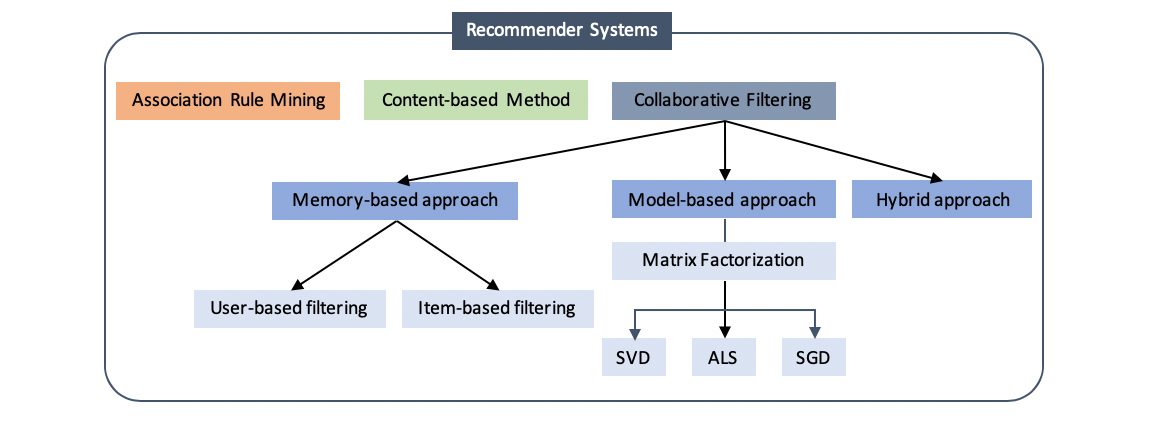

In this notebook we will implement the __Singular Value Decomposition__ technique from __model-based method__.

## 04. Singular value decomposition (SVD)

From a mathematical point of view, we can say given an actual m×n matrix A, there are orthogonal matrices U (of order m) and V (of order n) and a diagonal matrix Σ (of size m×n). This factorization of A is called Singular Value Decomposition,

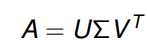

The diagonal elements of Σ are known as the singular values of the A. The columns of U are known as the left-singular vectors and are the eigenvectors of A*A. The columns of V are known as the right-singular vectors and are the eigenvectors of A*A.

The diagonal matrix Σ is uniquely determined by A. The nonzero singular values of A are the square roots of the eigenvalues A*A.

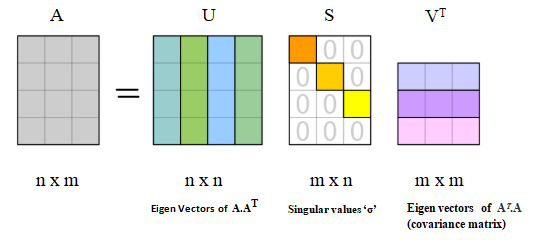

* __A__: Input data matrix.
* __U__: Left singular vectors.
* __V__: Right singular vectors.
* __Σ__: Singular values.

When it comes to dimensionality reduction, the Singular Value Decomposition (SVD) is a popular method in linear algebra for matrix factorization in machine learning. Such a method shrinks the space dimension from N-dimension to K-dimension (where K<N) and reduces the number of features. SVD constructs a matrix with the row of users and columns of items and the elements are given by the users’ ratings. Singular value decomposition decomposes a matrix into three other matrices and extracts the factors from the factorization of a high-level (user-item-rating) matrix.


In particular, in the case of recommendation systems Singular value decomposition (SVD) is a collaborative filtering method for item recommendation. For this technique, the interactions between users and products are stacked into a large matrix (the rating matrix), which has as many rows as users, and as many columns as products. And the aim for the code implementation is to provide users with recommendations from the latent features of item-user matrices.

Now we are going to implement this technique in our film recommendation system.

### Import Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # data splitting 
from scipy.sparse.linalg import svds # SVD model
import warnings
warnings.filterwarnings("ignore")

### Load data

For this purpose we only need the databases of movies and ratings.

In [68]:
df_movies = pd.read_csv('../../data/movies.csv', sep= ",")
df_ratings = pd.read_csv('../../data/ratings.csv', sep= ",")

We joined the two databases to facilitate the work.

In [69]:
# Merged data by movieId
data_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')
data_movies.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517


In [70]:
# we eliminate the column 'timestamp' for efficiency reasons as it includes information we do not need
data_movies.drop('timestamp', axis=1, inplace=True)

In [42]:
# shape of the data, 25.000.095 rows and 5 columns

print(data_movies.shape)

(25000095, 5)


### Splitting the data into train and test

Here we split the data randomnly into test and train datasets 70% train and 30% test for model training and prediction.

In [71]:
# we extract a sample of the data for use in the model as our database is very large

data_movies = data_movies.head(10000000)

In [72]:
data_train, data_test = train_test_split(data_movies, test_size = 0.3, random_state = 10)
data_train.head()

,movieId,title,genres,userId,rating
5399558,994,Big Night (1996),Comedy|Drama,127574,4.0
482292,39,Clueless (1995),Comedy|Romance,100224,3.5
1773327,266,Legends of the Fall (1994),Drama|Romance|War|Western,4859,4.0
5482645,1027,Robin Hood: Prince of Thieves (1991),Adventure|Drama,121774,3.0
7784201,1371,Star Trek: The Motion Picture (1979),Adventure|Sci-Fi,123772,2.5


### Singular Value Decomposition Model

Now we have to pivot the matrix to get a ratings matrix. We set the columns as title, the rows as userId and the values in the matrix will be the ratings.

In [73]:
# Pivoting the data for train and test
# the rating matrix will be full of null values, as most of the user's item interactions are unknown so we will replace 
# these null values with zeros

train_matrix = pd.pivot_table(data_train, index = 'userId', columns = 'title', values = 'rating').fillna(0)
test_matrix = pd.pivot_table(data_train, index = 'userId', columns = 'title', values = 'rating').fillna(0)

In [74]:
train_matrix.head()

title,'Til There Was You (1997),"'burbs, The (1989)",1-900 (06) (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (One Eight Seven) (1997),2 Days in the Valley (1996),2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her) (1967),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),...,Year of the Horse (1997),"Yes, Madam (a.k.a. Police Assassins) (a.k.a. In the Line of Duty 2) (Huang gu shi jie) (1985)",You Can't Take It with You (1938),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


And we normalize the data by each users mean and convert it from a dataframe to a numpy array to be able to carry out the decomposition of the matrix.

In [75]:
d_m = train_matrix.to_numpy()
avg_ratings = np.mean(d_m, axis = 1)

We are now ready to apply the matrix factorization with the Singular value decomposition (SVD) algorithm.

In [80]:
# Applying Singular Value Decomposition with the Scipy function svds

U, sigma, Vt = svds(train_matrix, k = 20) # k is the number of singular values and vectors to compute

In [77]:
print(U.shape) # orthogonal matrix containing the left single vectors of A

(161075, 20)


In [50]:
print(Vt.shape) # transposed matrix whose values are the unique vectors rights of A

(20, 1993)


In [81]:
# diagonal array in SVD, Σ diagonal matrix whose values are the singular values of matrix A ordered in decreasing value

sigma = np.diag(sigma)
print(sigma)

[[ 658.43835915    0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.          669.06477607    0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.          681.40720548    0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.          683.49636406    0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.      

In [82]:
print(sigma) # the singular values

[[ 658.43835915    0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.          669.06477607    0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.          681.40720548    0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.          683.49636406    0.
     0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.
     0.      

In [87]:
# and this is the final matrix

ratings_predict = np.dot(np.dot(U, sigma), Vt)
print(ratings_predict)

[[ 0.00026013 -0.00197309  0.00024236 ...  0.02529694  0.00190577
   0.00019548]
 [ 0.01223343  0.05646339 -0.00102608 ...  0.06995388 -0.00052519
   0.00452537]
 [-0.00824412 -0.03339408  0.00520375 ...  0.00415044  0.00542465
   0.00294764]
 ...
 [-0.01335881 -0.01917303 -0.00285504 ... -0.00432481  0.00132318
  -0.00462443]
 [ 0.00063869 -0.03227367  0.0008887  ... -0.00657523  0.0010056
   0.00072821]
 [ 0.00861464  0.07761896 -0.00083818 ...  0.09377216 -0.0007569
  -0.00012871]]


In [84]:
# adding the user averages back to get the actual ratings prediction

ratings_predict  = ratings_predict + avg_ratings.reshape(-1, 1)
print(ratings_predict)

[[ 0.01757072  0.0153375   0.01755295 ...  0.04260753  0.01921636
   0.01750607]
 [ 0.11509344  0.1593234   0.10183393 ...  0.17281389  0.10233482
   0.10738538]
 [ 0.07881057  0.05366061  0.09225844 ...  0.09120513  0.09247935
   0.09000234]
 ...
 [ 0.0403291   0.03451488  0.05083287 ...  0.0493631   0.05501109
   0.04906348]
 [ 0.00590713 -0.02700523  0.00615714 ... -0.0013068   0.00627404
   0.00599665]
 [ 0.10771148  0.1767158   0.09825866 ...  0.19286899  0.09833994
   0.09896813]]


### Predictions

In [88]:
# making predictions with the prediction matrix for every user using train data

predictions_df = pd.DataFrame(ratings_predict, columns = train_matrix.columns)
predictions_df.head()

title,'Til There Was You (1997),"'burbs, The (1989)",1-900 (06) (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (One Eight Seven) (1997),2 Days in the Valley (1996),2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her) (1967),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),...,Year of the Horse (1997),"Yes, Madam (a.k.a. Police Assassins) (a.k.a. In the Line of Duty 2) (Huang gu shi jie) (1985)",You Can't Take It with You (1938),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997)
0,0.000260,-0.001973,0.000242,0.001804,0.111839,0.002604,0.001636,0.006263,0.033676,0.289580,...,0.001359,0.000448,0.021784,0.015824,-0.038536,-0.015804,0.014023,0.025297,0.001906,0.000195
1,0.012233,0.056463,-0.001026,0.181665,0.102782,-0.008609,0.013559,-0.006584,0.235163,0.277396,...,-0.000709,0.001449,0.017958,0.532313,0.210936,0.074670,0.008857,0.069954,-0.000525,0.004525
2,-0.008244,-0.033394,0.005204,0.150598,0.551569,-0.006697,0.014088,0.010506,0.313867,2.160360,...,0.001817,0.003622,-0.011936,0.208887,-0.018561,-0.001621,0.056753,0.004150,0.005425,0.002948
3,-0.009244,0.028027,-0.006929,-0.124951,0.001822,-0.022876,-0.059193,-0.009491,0.107509,0.765342,...,-0.002391,-0.002795,-0.020537,0.498669,0.113695,0.014550,-0.019632,0.015388,-0.005421,-0.008328
4,0.029006,0.112843,0.008589,0.444713,0.236155,0.018937,0.137280,-0.002618,-0.119987,-0.417048,...,-0.000139,0.000568,0.008663,0.384133,0.120775,0.062764,0.033102,0.005806,-0.000097,0.013508


We create a function to return the movies with the highest predicted rating that the user we have randomly selected from our database has not yet rated.

In [89]:
def recommend_movies(userID, df_predict, train_matrix, num_recommend):
    
    user_index = userID - 1 # user index starts at 0
    
    # Get and sort the user's ratings and predictions
    sorted_user_ratings = train_matrix.iloc[user_index].sort_values(ascending = False) # sort the user ratings
    sorted_user_predicts = df_predict.iloc[user_index].sort_values(ascending = False) # sort the user predicts

    
     # Return recommendations of movies with the highest predicted rating that the user hasn't seen yet
    recom_df = pd.concat([sorted_user_ratings, sorted_user_predicts], axis = 1) # concat ratings and predicts
    recom_df.index.name = 'Recommended Items'   # title for the recommendation list
    recom_df.columns = ['u_ratings', 'u_predicts'] # user ratings and user predictions will be the columns
    
    recom_df = recom_df.loc[recom_df.u_ratings == 0] 
    recom_df = recom_df.sort_values('u_predicts', ascending = False) # sort values by user predictions 
    print('Here we have the recommended items for user {0}.'.format(userID))
    print(recom_df.head(num_recommend))


In order for the model to make the predictions we establish the number of users to whom we want to make recommendations and the number of recommendations we want to make 

In [90]:
# Here we give value to the parameters of the function 

userID = 152
num_recommend = 10
recommend_movies(userID, predictions_df, train_matrix, num_recommend)

Here we have the recommended items for user 152.
                                                    u_ratings  u_predicts
Recommended Items                                                        
Star Wars: Episode V - The Empire Strikes Back ...        0.0    1.321730
Star Wars: Episode VI - Return of the Jedi (1983)         0.0    1.022971
Raiders of the Lost Ark (Indiana Jones and the ...        0.0    0.434937
Good Will Hunting (1997)                                  0.0    0.377431
Apollo 13 (1995)                                          0.0    0.280593
Silence of the Lambs, The (1991)                          0.0    0.205152
One Flew Over the Cuckoo's Nest (1975)                    0.0    0.183852
Truman Show, The (1998)                                   0.0    0.181121
12 Angry Men (1957)                                       0.0    0.159455
Godfather, The (1972)                                     0.0    0.156085


### Evaluating the model

In [91]:
# Actual average rating for each item
# using test

test_matrix.mean().head()

title
'Til There Was You (1997)    0.005606
'burbs, The (1989)           0.043691
1-900 (06) (1994)            0.001791
101 Dalmatians (1996)        0.116374
12 Angry Men (1957)          0.305162
dtype: float64

In [92]:
# Singular Value Decomposition
U_t, sigma_t, Vt_t = svds(test_matrix, k = 20)

# Construct diagonal array in SVD
sigma_t = np.diag(sigma_t)

In [93]:
# Final matrix
test_predicted_ratings = np.dot(np.dot(U_t, sigma_t), Vt_t) 

# Predicted ratings
test_predict = pd.DataFrame(test_predicted_ratings, columns = test_matrix.columns)
test_predict.head()

title,'Til There Was You (1997),"'burbs, The (1989)",1-900 (06) (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (One Eight Seven) (1997),2 Days in the Valley (1996),2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her) (1967),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),...,Year of the Horse (1997),"Yes, Madam (a.k.a. Police Assassins) (a.k.a. In the Line of Duty 2) (Huang gu shi jie) (1985)",You Can't Take It with You (1938),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997)
0,0.000260,-0.001973,0.000242,0.001804,0.111839,0.002604,0.001636,0.006263,0.033676,0.289580,...,0.001359,0.000448,0.021784,0.015824,-0.038536,-0.015804,0.014023,0.025297,0.001906,0.000195
1,0.012233,0.056463,-0.001026,0.181665,0.102782,-0.008609,0.013559,-0.006584,0.235163,0.277396,...,-0.000709,0.001449,0.017958,0.532313,0.210936,0.074670,0.008857,0.069954,-0.000525,0.004525
2,-0.008244,-0.033394,0.005204,0.150598,0.551569,-0.006697,0.014088,0.010506,0.313867,2.160360,...,0.001817,0.003622,-0.011936,0.208887,-0.018561,-0.001621,0.056753,0.004150,0.005425,0.002948
3,-0.009244,0.028027,-0.006929,-0.124951,0.001822,-0.022876,-0.059193,-0.009491,0.107509,0.765342,...,-0.002391,-0.002795,-0.020537,0.498669,0.113695,0.014550,-0.019632,0.015388,-0.005421,-0.008328
4,0.029006,0.112843,0.008589,0.444713,0.236155,0.018937,0.137280,-0.002618,-0.119987,-0.417048,...,-0.000139,0.000568,0.008663,0.384133,0.120775,0.062764,0.033102,0.005806,-0.000097,0.013508


In [94]:
# Predicted average rating for each item

test_predict.mean().head()

title
'Til There Was You (1997)    0.005107
'burbs, The (1989)           0.040946
1-900 (06) (1994)            0.001304
101 Dalmatians (1996)        0.106807
12 Angry Men (1957)          0.308296
dtype: float64

To evaluate the model we will use the mean square error as a measure of accuracy, a standard way to measure the error of a model in predicting quantitative data. It is  a measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed

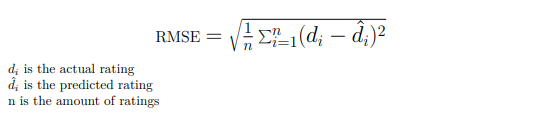

In [95]:
# Dataframe to calculate RMSE
df_rmse = pd.concat([test_matrix.mean(), test_predict.mean()], axis = 1) # concat test_matrix.mean and test_predict.mean to compare actual and predicted ratings
df_rmse.columns = ['average_actual_ratings', 'average_predicted_ratings']
print(df_rmse.shape)

# ordered by the index of the item
df_rmse['item_index'] = np.arange(0, df_rmse.shape[0], 1)
df_rmse.head()

(1993, 2)


,average_actual_ratings,average_predicted_ratings,item_index
title,,,
'Til There Was You (1997),0.005606,0.005107,0
"'burbs, The (1989)",0.043691,0.040946,1
1-900 (06) (1994),0.001791,0.001304,2
101 Dalmatians (1996),0.116374,0.106807,3
12 Angry Men (1957),0.305162,0.308296,4


In [96]:
# Root mean square error: measure of the differences between values predicted by a model or an estimator and the values observed

RMSE = round((((df_rmse.average_actual_ratings - df_rmse.average_predicted_ratings) ** 2).mean() ** 0.5), 4)
print('\nThe RMSE of the SVD Model is = {} \n'.format(RMSE))


The RMSE of the SVD Model is = 0.0041 



As can be seen in the table above and checked with the result of the error the model is quite adequate as there is very little difference between the current average scores and the predicted average scores for the recommended films.

Now let's train on the data set and get the predictions for a random user.

In [97]:
# Singular Value Decomposition
U, sigma, Vt = svds(train_matrix, k = 20)

# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [65]:
pre_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(pre_ratings, columns = train_matrix.columns)

In [98]:
# Here we give value to the parameters of the function 

userID = 1356
num_recommend = 10
recommend_movies(userID, preds_df, train_matrix, num_recommend)

Here we have the recommended items for user 1356.
                                    u_ratings  u_predicts
Recommended Items                                        
Men in Black (a.k.a. MIB) (1997)          0.0    2.330755
Terminator, The (1984)                    0.0    2.040459
Rock, The (1996)                          0.0    1.863839
Terminator 2: Judgment Day (1991)         0.0    1.701910
Die Hard (1988)                           0.0    1.689549
Jurassic Park (1993)                      0.0    1.669965
Alien (1979)                              0.0    1.669794
Star Trek: First Contact (1996)           0.0    1.629826
Back to the Future Part II (1989)         0.0    1.601893
Back to the Future Part III (1990)        0.0    1.505287


# Conclusion

There are two problems in applying the SVD. The first one is how to deal with those items that the user has not evaluated, because if that item is evaluated with a value of 0 the prediction will be of a value very close to 0 and that is not the expected result. The second problem that arises is the dispersion that the voting matrixes have; that is, the user only votes a very small percentage of the items that are in the system, so you have to work with widely dispersed voting matrices.
